8. Swap to mid price (keep reward fn of bid ask spread)
9. Pretraining
10. Feature encoder layer
11. Adjust rewards, could optionally multiply penalties by 2. (I.e. losing \\$1 is twice as bad as making \\$1)

Create 4 graphs:
- Mid price and no mid price
- High dim and low dim

Each graph should have each of the following algorithms:
- DQN
- DDQN
- Actor Critic
- Advantage Actor Critic
- PPO A2C

In [1]:
import random
from time import sleep
from IPython.display import clear_output

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torch.distributions.categorical import Categorical

from commons.replay_memory import ReplayMemory, Experience

%matplotlib inline

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
env = gym.make('CartPole-v1')

## 1. Random approach

In [3]:
epochs = 500
reward_history = []
step_history = []

for epoch in range(epochs):
    state = env.reset()    
    done = False
    step_count = 0
    ep_reward = 0
    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        ep_reward += reward
        step_count += 1
    reward_history.append(ep_reward)
    step_history.append(step_count)

<AxesSubplot:>

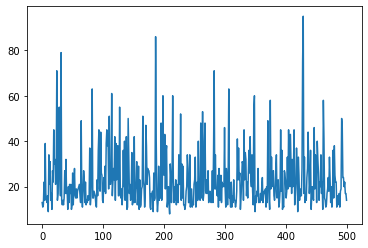

In [4]:
pd.Series(reward_history).plot()

In [5]:
pd.Series(reward_history).mean()

23.106

Learning points:
- In Q Learning the exploration-exploitation tradeoff is really important. The agent MUST explore
- The discount rate is really important for feeding information back in time, always try it with different values
- Learning rate is important for stability, need to slowly move to the target, also know that the target will move too
- When we use a NN with input_dim = OBSERVATION_SPACE and output_dim = ACTION_SPACE, then select single actions to backprop by, the weight update of all other action values are not controlled by us. The assumption is that they should not be changed, but this might not necessarily be true.

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

class StateValue(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.linear_stack = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 16),
            nn.ReLU(),
            nn.Linear(16, env.action_space.n)
        )
        self.apply(init_weights)
        
    def forward(self, x):
        # x = torch.nn.functional.one_hot(x, num_classes=self.env.observation_space.n).float()
        return self.linear_stack(x)

# TODO:
- Use double Q learning (frozen network that we update)
- Batch learning via experience replay
- Try AC approach if i have to

NOTE: When I swapped it to a purely linear network it was able to learn, but any higher and it would overfit.  
Understandable as FrozenLake is a noisy environment.  

Currently win rate is not increasing, need to find out why and fix.

## DQN

<AxesSubplot:>

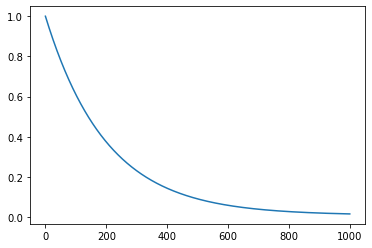

In [7]:
min_exploration_rate = 0.01
max_exploration_rate = 1.
exploration_decay_rate = 0.005
ers = []
for epoch in range(1000):
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*epoch)
    ers.append(exploration_rate)

pd.Series(ers).plot()

In [8]:
epochs = 1000
steps = 5000
target_update = 64

discount_rate = 0.99
batch_size = 100

min_exploration_rate = 0.01
max_exploration_rate = 1.
exploration_decay_rate = 0.005

reward_history = []
step_history = []

q_fn = StateValue(env).to(device)
q_fn_frozen = StateValue(env).to(device)
q_fn_frozen.load_state_dict(q_fn.state_dict())

q_fn.train()
q_fn_frozen.eval()

replay_memory = ReplayMemory(50000)

optimizer = torch.optim.Adam(q_fn.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    done = False
    episode_reward = 0
    episode_step = 0
    state = torch.tensor(env.reset()).to(device)
    while not done:
        
        # Explore vs exploit
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*epoch)
        if random.uniform(0, 1) > exploration_rate:
            action = q_fn(state).argmax()
        else:
            action = torch.tensor(env.action_space.sample()).to(device)
            
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor(next_state).to(device)
        replay_memory.push(Experience(state, action.item(), reward, next_state, done))
        
        if replay_memory.can_provide_sample(batch_size):
            states, actions, rewards, next_states, dones = replay_memory.sample(batch_size)
            states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
            actions = actions.long().unsqueeze(-1)
            dones = dones.float()
            
            # Error calculation
            action_targets = q_fn(next_states).max(dim=-1)[1].unsqueeze(-1)
            # target_values = rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
            target_values = rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).max(dim=-1)[0] # DQN
            
            current_values = q_fn(states).gather(-1, actions).squeeze(1)

            # Loss
            loss = loss_fn(current_values, target_values.detach())
            optimizer.zero_grad()
            loss.backward()
            # print(q_fn.linear_stack[0].weight.grad.max())
            optimizer.step()

        state = next_state
        episode_reward += reward
        episode_step += 1
    
    reward_history.append(episode_reward)
    step_history.append(episode_step)
    if (replay_memory.can_provide_sample(batch_size)) and (epoch % target_update) == 0:
        q_fn_frozen.load_state_dict(q_fn.state_dict())
    
    if (replay_memory.can_provide_sample(batch_size)):
        print(f"Rewards: {pd.Series(reward_history)[-200:].mean():10.3f}, Epoch: {epoch:6}, Loss: {loss.item():10.5f}", end="\r")

<AxesSubplot:>

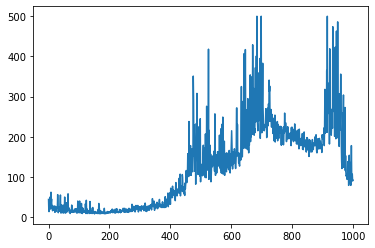

In [9]:
pd.Series(reward_history).plot()

In [10]:
pd.Series(reward_history).mean()

119.348

## DDQN

<AxesSubplot:>

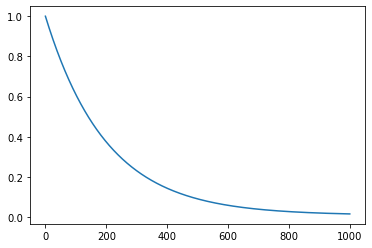

In [11]:
min_exploration_rate = 0.01
max_exploration_rate = 1.
exploration_decay_rate = 0.005
ers = []
for epoch in range(1000):
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*epoch)
    ers.append(exploration_rate)

pd.Series(ers).plot()

In [12]:
epochs = 1000
steps = 5000
target_update = 64

discount_rate = 0.99
batch_size = 100

min_exploration_rate = 0.01
max_exploration_rate = 1.
exploration_decay_rate = 0.005

reward_history2 = []
step_history2 = []

q_fn = StateValue(env).to(device)
q_fn_frozen = StateValue(env).to(device)
q_fn_frozen.load_state_dict(q_fn.state_dict())

q_fn.train()
q_fn_frozen.eval()

replay_memory = ReplayMemory(50000)

optimizer = torch.optim.Adam(q_fn.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    done = False
    episode_reward = 0
    episode_step = 0
    state = torch.tensor(env.reset()).to(device)
    while not done:
        
        # Explore vs exploit
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*epoch)
        if random.uniform(0, 1) > exploration_rate:
            action = q_fn(state).argmax()
        else:
            action = torch.tensor(env.action_space.sample()).to(device)
            
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor(next_state).to(device)
        replay_memory.push(Experience(state, action.item(), reward, next_state, done))
        
        if replay_memory.can_provide_sample(batch_size):
            states, actions, rewards, next_states, dones = replay_memory.sample(batch_size)
            states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
            actions = actions.long().unsqueeze(-1)
            dones = dones.float()
            
            # Error calculation
            action_targets = q_fn(next_states).max(dim=-1)[1].unsqueeze(-1)
            target_values = rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
            # target_values = rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).max(dim=-1)[0] # DQN
            
            current_values = q_fn(states).gather(-1, actions).squeeze(1)

            # Loss
            loss = loss_fn(current_values, target_values.detach())
            optimizer.zero_grad()
            loss.backward()
            # print(q_fn.linear_stack[0].weight.grad.max())
            optimizer.step()

        state = next_state
        episode_reward += reward
        episode_step += 1
    
    reward_history2.append(episode_reward)
    step_history2.append(episode_step)
    if (replay_memory.can_provide_sample(batch_size)) and (epoch % target_update) == 0:
        q_fn_frozen.load_state_dict(q_fn.state_dict())
    if (replay_memory.can_provide_sample(batch_size)):
        print(f"Rewards: {pd.Series(reward_history2)[-200:].mean():10.3f}, Epoch: {epoch:6}, Loss: {loss.item():10.5f}", end="\r")

<AxesSubplot:>

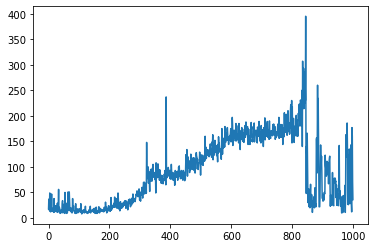

In [13]:
pd.Series(reward_history2).plot()

In [14]:
pd.Series(reward_history2).mean()

91.145

## Actor Critic

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

class ValueFunction(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.linear_stack = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        self.apply(init_weights)
        
    def forward(self, x):
        # x = torch.nn.functional.one_hot(x, num_classes=self.env.observation_space.n).float()
        return self.linear_stack(x)

class PolicyFunction(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.linear_stack = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 16),
            nn.ReLU(),
            nn.Linear(16, env.action_space.n)
        )
        self.apply(init_weights)
        
    def forward(self, x):
        with torch.no_grad():
            logits = self.linear_stack(x)
            probs = Categorical(logits=logits)
            action = probs.sample()
        return action
    
    def get_log_prob(self, state, action):
        logits = self.linear_stack(state)
        dist = Categorical(logits=logits)
        return dist.log_prob(action)

<AxesSubplot:>

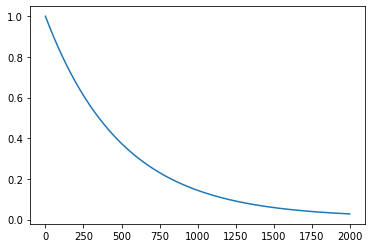

In [16]:
min_exploration_rate = 0.01
max_exploration_rate = 1.
exploration_decay_rate = 0.002
ers = []
for epoch in range(2000):
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*epoch)
    ers.append(exploration_rate)

pd.Series(ers).plot()

In [17]:
epochs = 2000
steps = 5000
target_update = 64

discount_rate = 0.99
batch_size = 256

min_exploration_rate = 0.01
max_exploration_rate = 1.
exploration_decay_rate = 0.002

reward_history3 = []
step_history3 = []

q_fn = ValueFunction(env).to(device)
q_fn_frozen = ValueFunction(env).to(device)
q_fn_frozen.load_state_dict(q_fn.state_dict())

q_fn.train()
q_fn_frozen.eval()

p_fn = PolicyFunction(env).to(device)
p_fn.train()

replay_memory = ReplayMemory(50000)

q_optimizer = torch.optim.Adam(q_fn.parameters(), lr=5e-4)
p_optimizer = torch.optim.Adam(p_fn.parameters(), lr=5e-4)

mse_fn = nn.MSELoss()

# Value Function is supposed to be using the current policy, check that this is the case.
# I.e. that our state transitions are because of our policy. [ Exploration vs exploitation is one factor that violates this, another is that our Value network does not accept the policy ]

for epoch in range(epochs):
    done = False
    episode_reward = 0
    episode_step = 0
    state = torch.tensor(env.reset()).to(device)
    while not done:
        
        # Explore vs exploit
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*epoch)
        if random.uniform(0, 1) > exploration_rate:
            action = p_fn(state)
        else:
            action = torch.tensor(env.action_space.sample()).to(device)
            
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor(next_state).to(device)
        replay_memory.push(Experience(state, action.item(), reward, next_state, done))
        
        if replay_memory.can_provide_sample(batch_size):
            states, actions, rewards, next_states, dones = replay_memory.sample(batch_size)
            states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
            actions = actions.long()
            dones = dones.float()
            
            # Error calculation
            # action_targets = q_fn(next_states).max(dim=-1)[1].unsqueeze(-1) # Double DQN
            # target_values = rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
            # target_values = rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).max(dim=-1)[0] # DQN
            log_probs = p_fn.get_log_prob(states, actions)
            q_values_s1 = q_fn(states).squeeze(-1)
            q_target = (rewards + (1 - dones) * discount_rate * q_fn_frozen(next_states).squeeze(-1)).detach()
            advantages = q_target - q_values_s1
            
            policy_loss = -(log_probs * advantages.detach()).mean()
            value_loss = mse_fn(q_target, q_values_s1)
            # current_values = q_fn(states).gather(-1, actions).squeeze(1)

            # Loss
            q_optimizer.zero_grad()
            value_loss.backward()
            q_optimizer.step()
            
            p_optimizer.zero_grad()
            policy_loss.backward()
            p_optimizer.step()


        state = next_state
        episode_reward += reward
        episode_step += 1
    
    reward_history3.append(episode_reward)
    step_history3.append(episode_step)
    if (replay_memory.can_provide_sample(batch_size)) and (epoch % target_update) == 0:
        q_fn_frozen.load_state_dict(q_fn.state_dict())
    if (replay_memory.can_provide_sample(batch_size)):
        print(f"Rewards: {pd.Series(reward_history3)[-200:].mean():10.3f}, Epoch: {epoch:6}, Policy Loss: {policy_loss.item():10.5f}, Value Loss: {value_loss.item():10.5f}\
        Number of zeros in log_probs: {(log_probs == 0).float().mean():6.5f}", end="\r")

<AxesSubplot:>

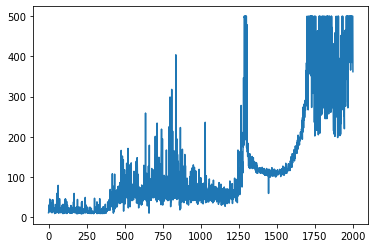

In [18]:
pd.Series(reward_history3).plot()

In [20]:
pd.Series(reward_history3[-200:]).mean()

377.1